In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

https://www.bls.gov/oes/current/naics3_334000.htm

https://fred.stlouisfed.org/series/PCU334334

In [2]:
df = pd.read_csv('RawData/332322_Sheet Metal Work manufacturing.csv')

In [3]:
df.head()

,DATE,PCU332322332322
0,1982-12-01,100.0
1,1983-01-01,99.4
2,1983-02-01,99.7
3,1983-03-01,100.1
4,1983-04-01,100.3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DATE             486 non-null    object 
 1   PCU332322332322  486 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.7+ KB


In [5]:
df['Price'] = df['PCU332322332322']
df_new = df.drop(['PCU332322332322'],axis=1)
df_new['Date']= pd.to_datetime(df_new['DATE'])
df_new =  df_new.set_index(df_new['Date'])
df_new.drop(['Date','DATE'], axis=1 , inplace=True)
df_new.head()

,Price
Date,
1982-12-01,100.0
1983-01-01,99.4
1983-02-01,99.7
1983-03-01,100.1
1983-04-01,100.3


<Axes: xlabel='Date'>

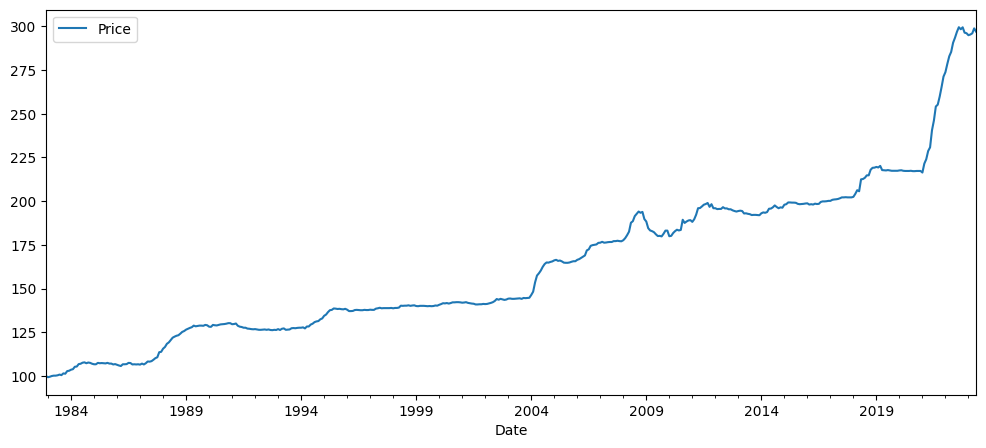

In [6]:
df_new.plot(figsize=(12,5))

## Data Cleaning

In [7]:
df_new.isnull().sum()

Price    0
dtype: int64

In [8]:
# df.dropna(inplace = True)
# df.reset_index(drop=False,inplace=True)

In [9]:
df_new.shape

(486, 1)

In [10]:
df_new = df_new.iloc[252:]

In [11]:
df_new.shape

(234, 1)

In [12]:
df_new = df_new.sort_values('Date', ascending=True)
df_new.index.freq = 'MS'

In [13]:
df_new.head()

,Price
Date,
2003-12-01,144.8
2004-01-01,146.4
2004-02-01,148.3
2004-03-01,153.6
2004-04-01,157.5


In [14]:
# df_new = df_new.iloc[110:]

<Axes: xlabel='Date', ylabel='Price'>

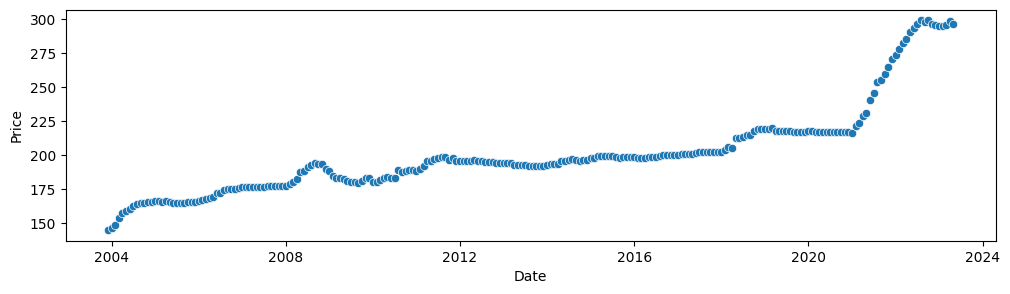

In [15]:
plt.figure(figsize=(12,3))

sns.scatterplot(x=df_new.index, y=df_new['Price'])

<Axes: >

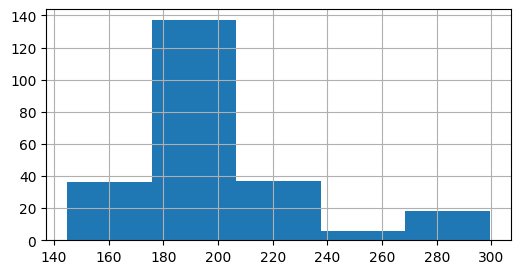

In [16]:
plt.figure(figsize=(6,3))

df_new['Price'].hist(bins=5)

<Axes: >

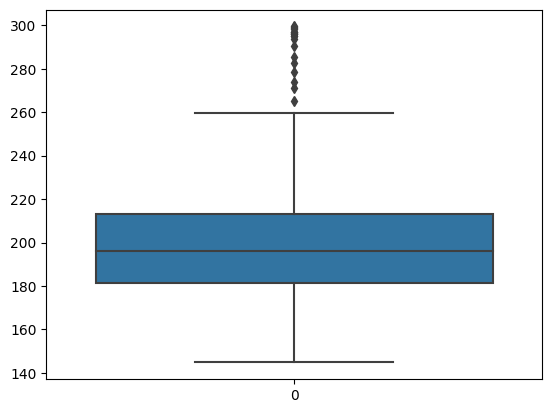

In [17]:
sns.boxplot(df_new['Price'])

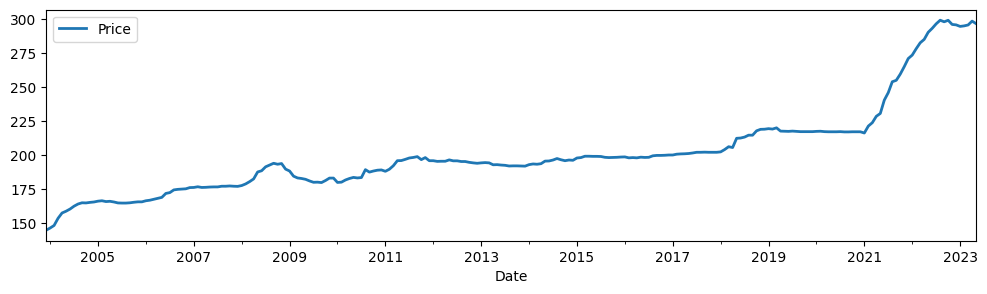

In [18]:
df_new.plot.line(y='Price',figsize=(12,3),lw=2);

<Axes: title={'center': 'Seasonality of the Time Series'}, xlabel='Month', ylabel='Price'>

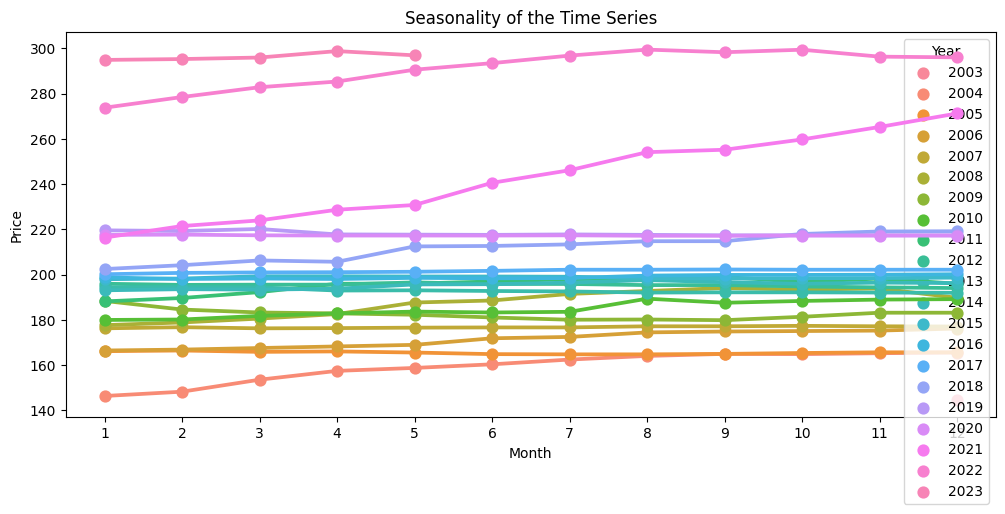

In [19]:
# To plot the seasonality we are going to create a temp dataframe and add columns for Month and Year values
df_temp = df_new.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month
# Stacked line plot
plt.figure(figsize=(12,5))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='Month',y='Price',hue='Year',data=df_temp)

https://www.metafab.com/steel-prices-growth-in-metal-fabrication/

In [20]:
df_pre = df_new[:'2020-03-1']
df_pandemic = df_new['2020-03-1':'2022-01-01']
df_post = df_new['2022-01-01':]

<Axes: xlabel='Date'>

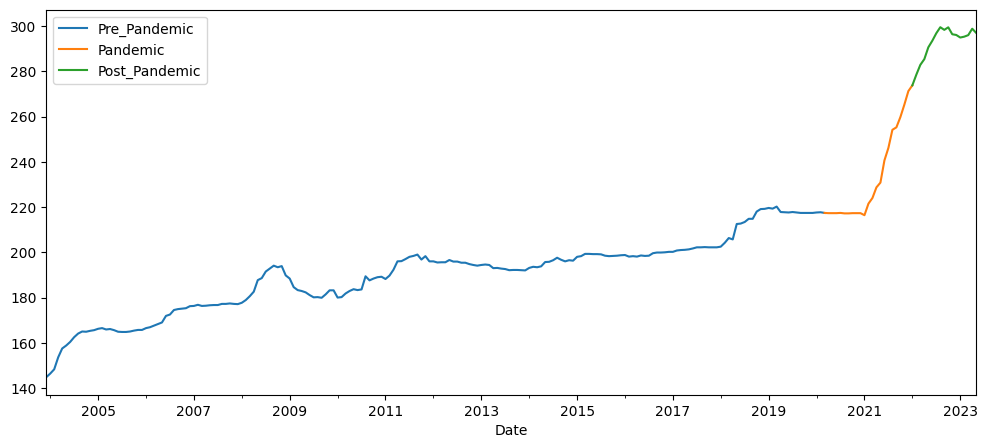

In [21]:
df_pre['Price'].plot(legend=True, label='Pre_Pandemic',figsize=(12,5))
df_pandemic['Price'].plot(legend=True, label='Pandemic')
df_post['Price'].plot(legend=True, label = 'Post_Pandemic')

## Decomposition of Time Series

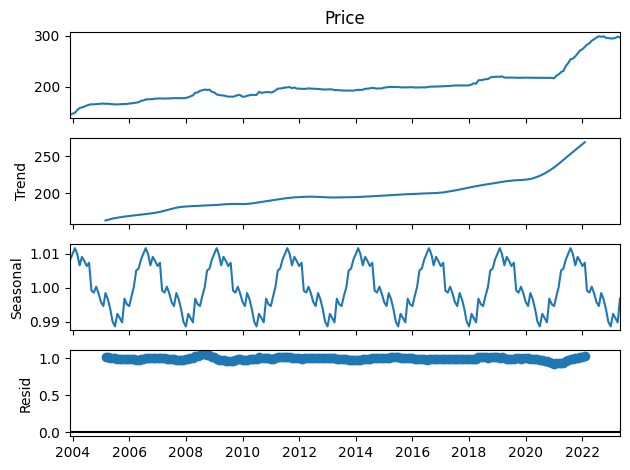

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_new['Price'], model='multiplicative',period=30)  # model='mul' also works
result.plot();

## Simple Moving Average (SMA)

In [23]:
df_new['12-month-SMA'] = df_new['Price'].rolling(window=12).mean()

<Axes: xlabel='Date'>

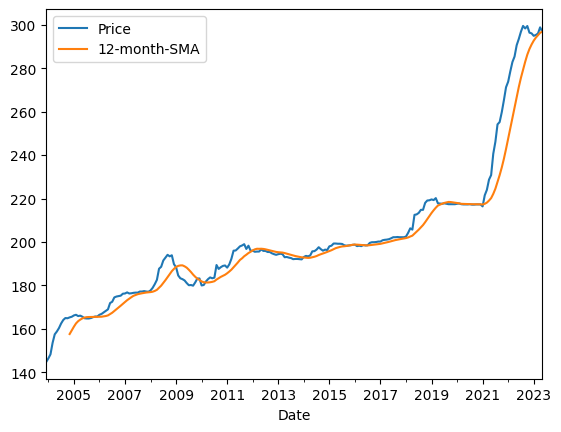

In [24]:
df_new[['Price','12-month-SMA']].plot()

## Exponentially Weighted Moving Average (EWMA)

In [25]:
df_new['EWMA12'] = df_new['Price'].ewm(span=12,adjust=False).mean()

<Axes: xlabel='Date'>

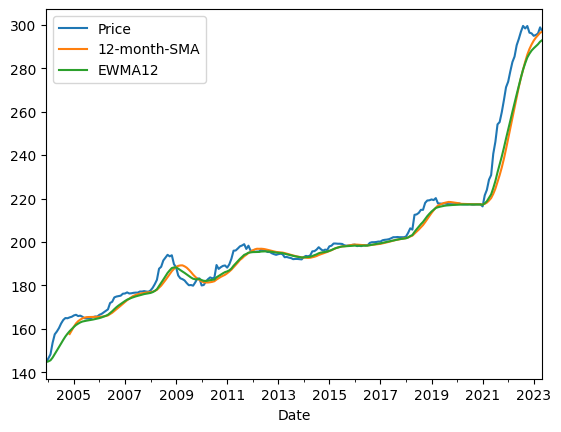

In [26]:
df_new[['Price','12-month-SMA','EWMA12']].plot()

## Comparing SMA to EWMA

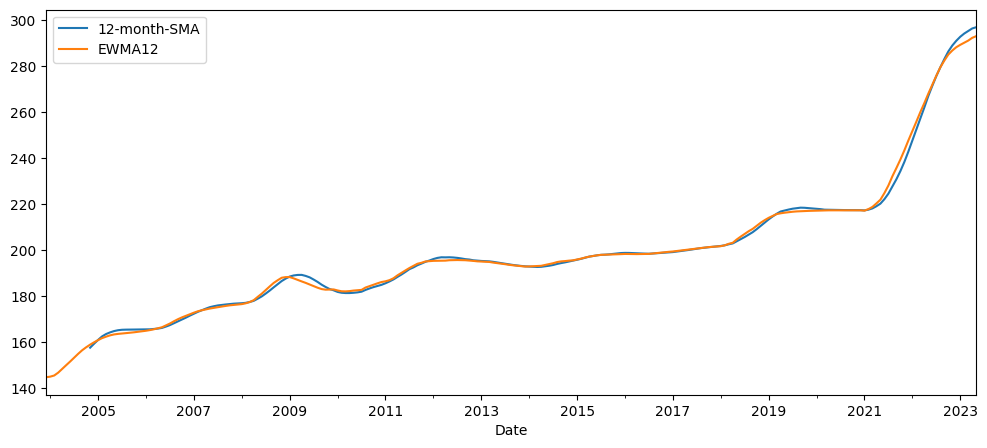

In [27]:
df_new[['12-month-SMA','EWMA12']].plot(figsize=(12,5)).autoscale(axis='x',tight=True);

https://stackoverflow.com/questions/60017052/decompose-for-time-series-valueerror-you-must-specify-a-period-or-x-must-be

## Check for Stationarity

### Augmented Dickey Fuller (ADF) Test 

#### p-value > 0.05: non-stationary.
#### p-value <= 0.05: stationary.
#### Test statistics: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series

In [28]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Month')
    plt.ylabel('Item_Price')    
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')   
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

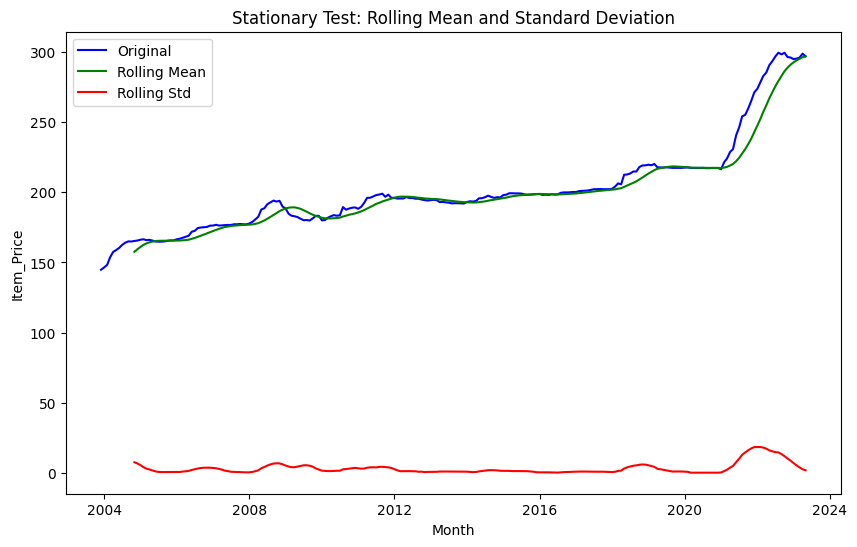

Results of Dickey-Fuller Test
Test Statistic                   1.149038
p-value                          0.995614
#Lags Used                       7.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64


In [29]:
stationarity_test(df_new['Price'])

### Differencing

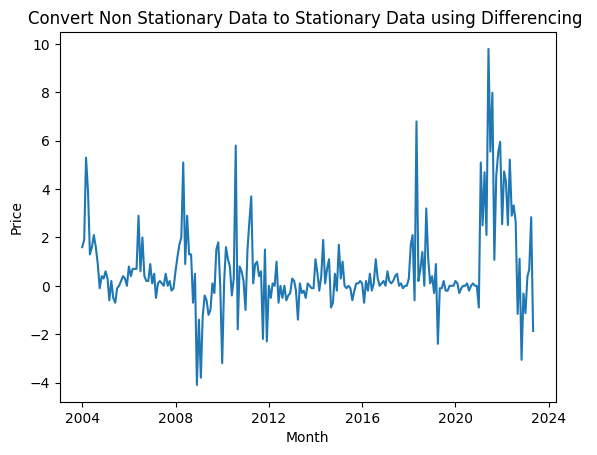

In [30]:
df_diff = df_new['Price'].diff(periods = 1) # First order differencing
plt.xlabel('Month')
plt.ylabel('Price')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_diff)

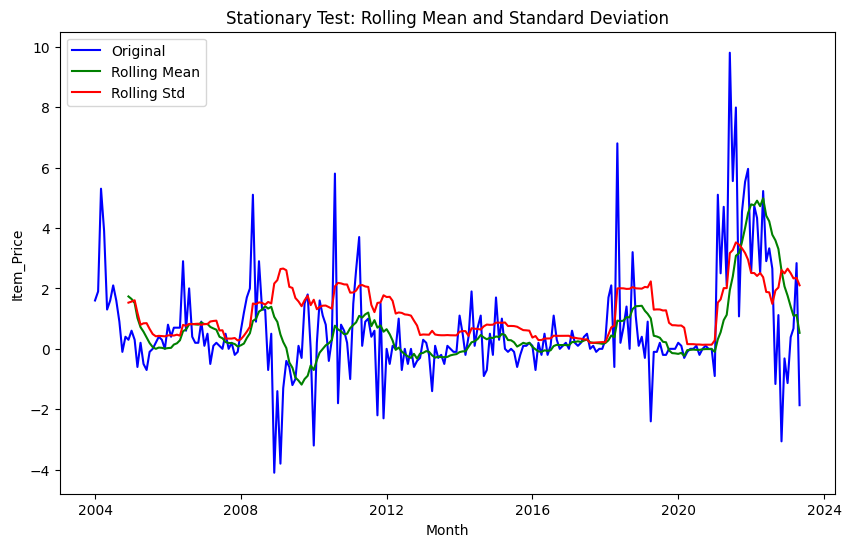

Results of Dickey-Fuller Test
Test Statistic                  -4.418434
p-value                          0.000275
#Lags Used                       6.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64


In [31]:
df_diff.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_diff)

### Transformation

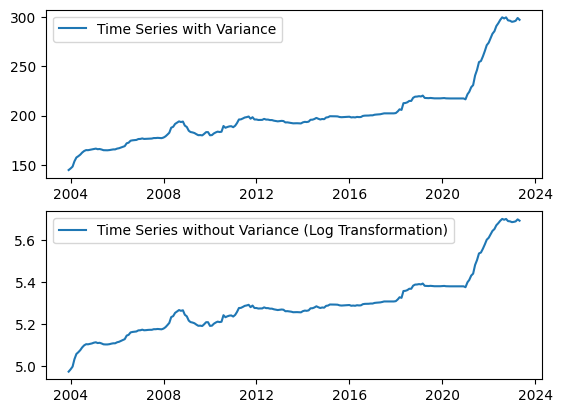

In [32]:
df_log = np.log(df_new['Price'])

plt.subplot(211)
plt.plot(df_new['Price'], label= 'Time Series with Variance')
plt.legend()
plt.subplot(212)
plt.plot(df_log, label='Time Series without Variance (Log Transformation)')
plt.legend()  
plt.show()

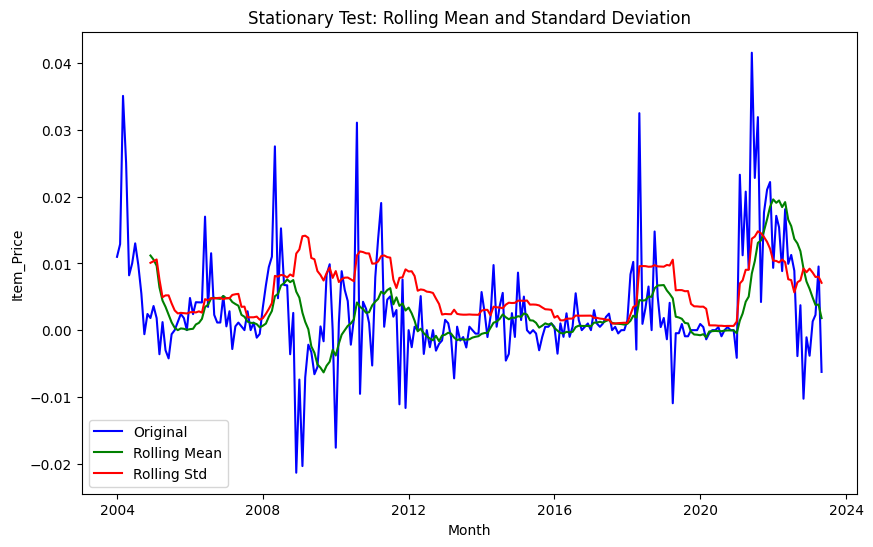

Results of Dickey-Fuller Test
Test Statistic                  -4.943385
p-value                          0.000029
#Lags Used                       6.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64


In [33]:
df_log_diff = df_log.diff(periods = 1) # First order differencing

df_log_diff.dropna(inplace = True)# Data transformation may add na values

stationarity_test(df_log_diff)

In [34]:
df_new= df_new.drop(['12-month-SMA','EWMA12'],axis=1)

In [35]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 234 entries, 2003-12-01 to 2023-05-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   234 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB


In [36]:
# df_new['Price'].plot(figsize=(10,5))

## Forecasting with the Holt-Winters Method

### Train Test Split

In [37]:
train_data = df_new.iloc[:222] # Goes up to but not including 101
test_data = df_new.iloc[222:]

### Fitting the Model

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['Price'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

C:\Users\msalehi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


### Evaluating Model against Test Set

In [39]:
test_predictions = fitted_model.forecast(12).rename('HW Forecast')

In [40]:
test_predictions

2022-06-01    294.745310
2022-07-01    298.965082
2022-08-01    303.916498
2022-09-01    307.084210
2022-10-01    310.845443
2022-11-01    315.131655
2022-12-01    318.521478
2023-01-01    321.910005
2023-02-01    326.311094
2023-03-01    331.199131
2023-04-01    335.556093
2023-05-01    341.042976
Freq: MS, Name: HW Forecast, dtype: float64

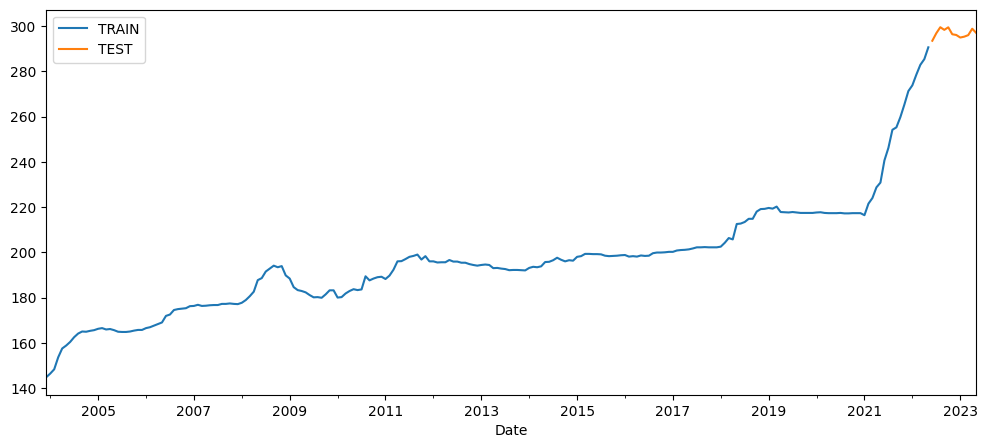

In [41]:
train_data['Price'].plot(legend=True,label='TRAIN')
test_data['Price'].plot(legend=True,label='TEST',figsize=(12,5));

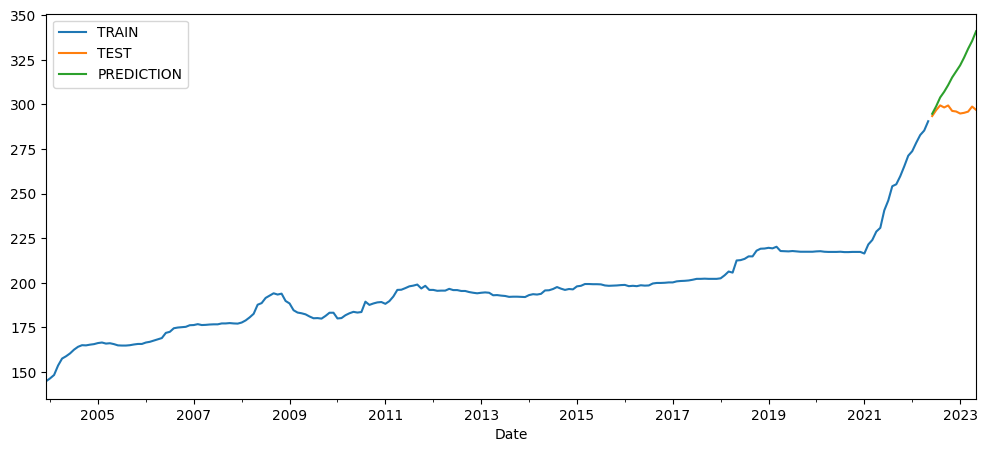

In [42]:
train_data['Price'].plot(legend=True,label='TRAIN')
test_data['Price'].plot(legend=True,label='TEST',figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION');

In [43]:
final_model = ExponentialSmoothing(df_new['Price'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

C:\Users\msalehi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [44]:
forecast_predictions = final_model.forecast(12)

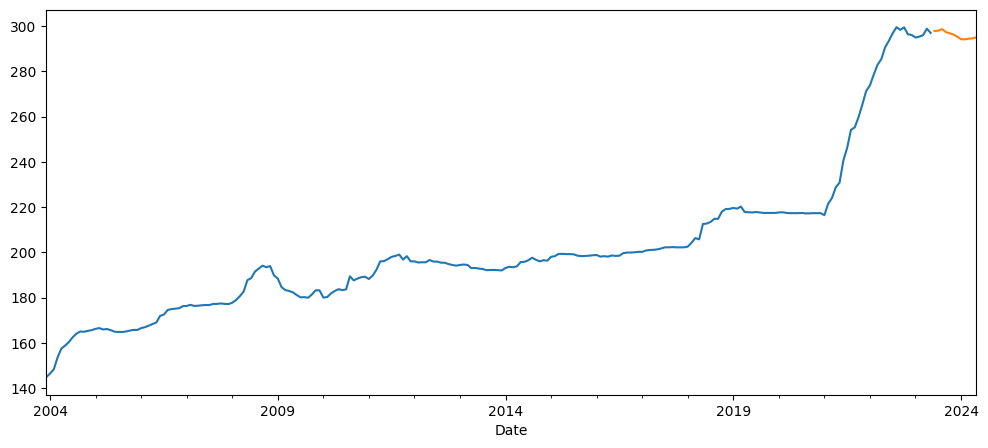

In [45]:
df_new['Price'].plot(figsize=(12,5))
forecast_predictions.plot();

### Evaluation Metrics

In [46]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [47]:
mean_absolute_error(test_data,test_predictions)

20.289414579958777

In [48]:
mean_squared_error(test_data,test_predictions)

610.129476433205

In [49]:
np.sqrt(mean_squared_error(test_data,test_predictions))

24.700799105154573

In [50]:
df_new['Price'].describe()

count    234.000000
mean     201.218444
std       32.483160
min      144.800000
25%      181.500000
50%      196.000000
75%      213.225000
max      299.462000
Name: Price, dtype: float64

## AR(p)
### Autoregressive Model

## Lagging
Also known as "backshifting", lagging notation reflects the value of $y$ at a prior point in time. This is a useful technique for performing <em>regressions</em> as we'll see in upcoming sections.

\begin{split}L{y_t} = y_{t-1} & \text{      one lag shifts the data back one period}\\
L^{2}{y_t} = y_{t-2} & \text{      two lags shift the data back two periods} \end{split}
<br><br>
<table>
<tr><td>$y_t$</td><td>6</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-1}$</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-2}$</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
</table>


In [51]:
# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

In [52]:
from statsmodels.tsa.ar_model import AutoReg

In [53]:
df_new.head()

,Price
Date,
2003-12-01,144.8
2004-01-01,146.4
2004-02-01,148.3
2004-03-01,153.6
2004-04-01,157.5


In [54]:
# Set one year for testing
train = df_new.iloc[:112]
test = df_new.iloc[112:]

### Fit an AR(1) Model

In [55]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [56]:
model = AutoReg(train['Price'], lags=1)
AR1fit = model.fit()
print(f'Coefficients:\n{AR1fit.params}')

Coefficients:
const       6.707976
Price.L1    0.965191
dtype: float64


In [57]:
# This is the general format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

In [58]:
predictions1

2013-04-01    194.341113
2013-05-01    194.284276
2013-06-01    194.229418
2013-07-01    194.176469
2013-08-01    194.125363
                 ...    
2023-01-01    192.734155
2023-02-01    192.733254
2023-03-01    192.732385
2023-04-01    192.731547
2023-05-01    192.730737
Freq: MS, Name: AR(1) Predictions, Length: 122, dtype: float64

<Axes: xlabel='Date'>

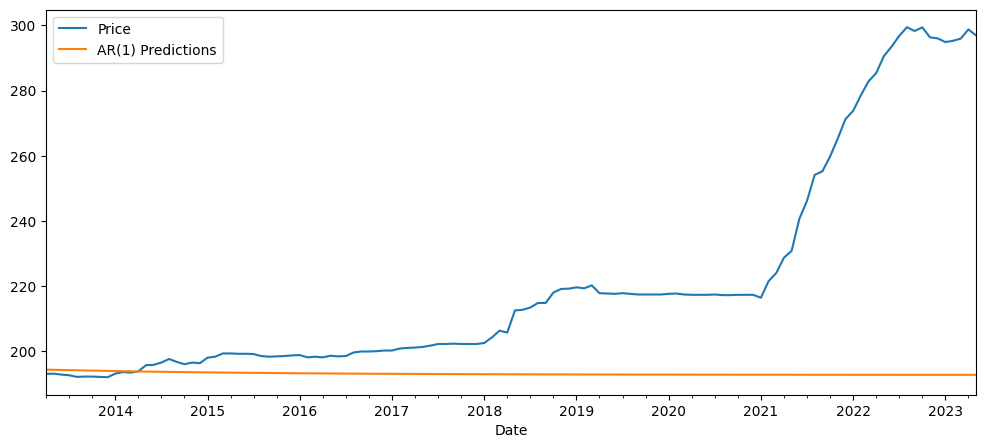

In [59]:
test.plot(figsize=(12,5), legend=True)
predictions1.plot(legend=True)

### Fit an AR(2) Model

In [60]:
model = AutoReg(train['Price'], lags=2)
AR2fit = model.fit()
print(f'Coefficients:\n{AR2fit.params}')

Coefficients:
const       5.462875
Price.L1    1.252106
Price.L2   -0.280707
dtype: float64


In [61]:
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

<Axes: xlabel='Date'>

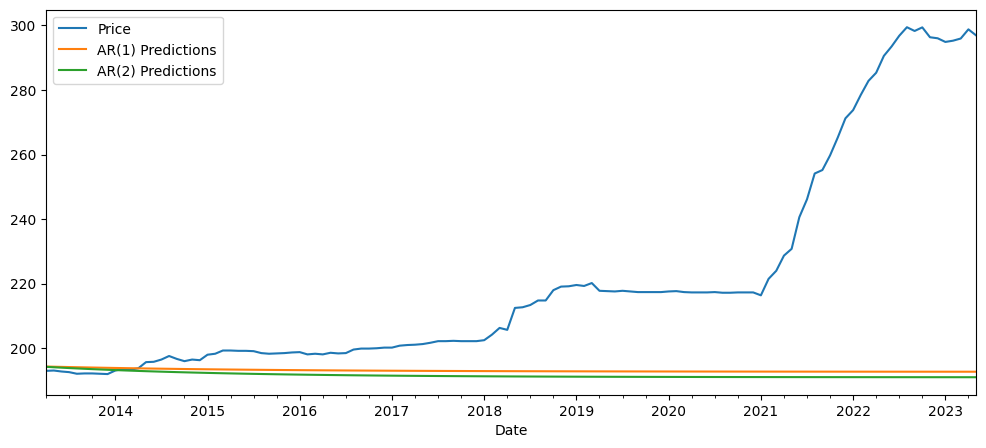

In [62]:
test.plot(figsize=(12,5), legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)

### Fit an AR(p) model where statsmodels chooses p

In [63]:
# Define a range of lags to consider
lags_range = range(1, 10)

# Initialize variables for best AIC and best lag
best_aic = float("inf")
best_lag = None

# Iterate over the lags and fit AutoReg models
for lag in lags_range:
    model = AutoReg(train['Price'], lags=lag)
    fit = model.fit()
    
    # Check if the current model has lower AIC
    if fit.aic < best_aic:
        best_aic = fit.aic
        best_lag = lag

# Fit the AutoReg model with the best lag
best_model = AutoReg(train['Price'], lags=best_lag)
best_fit = best_model.fit()
print(f'Lag: {best_lag}')
print(f'Coefficients:\n{best_fit.params}')

Lag: 9
Coefficients:
const       3.200641
Price.L1    1.130159
Price.L2    0.113269
Price.L3   -0.226499
Price.L4    0.086404
Price.L5   -0.129179
Price.L6   -0.026579
Price.L7   -0.178859
Price.L8    0.234327
Price.L9   -0.019424
dtype: float64


In [64]:
model = AutoReg(train['Price'], lags=9)
AR9fit = model.fit()
print(f'Coefficients:\n{AR9fit.params}')

Coefficients:
const       3.200641
Price.L1    1.130159
Price.L2    0.113269
Price.L3   -0.226499
Price.L4    0.086404
Price.L5   -0.129179
Price.L6   -0.026579
Price.L7   -0.178859
Price.L8    0.234327
Price.L9   -0.019424
dtype: float64


In [65]:
predictions9 = AR9fit.predict(start=start, end=end, dynamic=False).rename('AR(9) Predictions')

<Axes: xlabel='Date'>

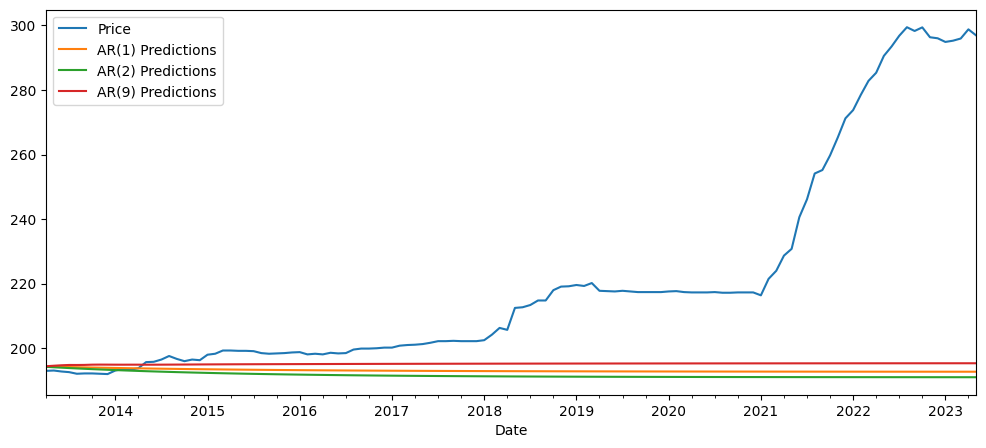

In [66]:
test.plot(figsize=(12,5), legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions9.plot(legend=True)

### Evaluate the Model
It helps to have a means of comparison between two or more models. One common method is to compute the Mean Squared Error (MSE), available from scikit-learn

In [67]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(9)']
preds = [predictions1, predictions2, predictions9]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['Price'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error:  1848.01045
AR(2) Error: 1942.891718
AR(9) Error: 1713.510717


In [68]:
np.sqrt(mean_squared_error(test['Price'],predictions9))

41.394573525499155

Another method is the Akaike information criterion (AIC), which does a better job of evaluating models by avoiding overfitting.
Fortunately this is available directly from the fit model object.

In [69]:
modls = [AR1fit,AR2fit,AR9fit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 397.78
AR(2) AIC: 387.65
AR(9) AIC: 357.05


### Forecasting
Now we're ready to train our best model on the greatest amount of data, and fit it to future dates.

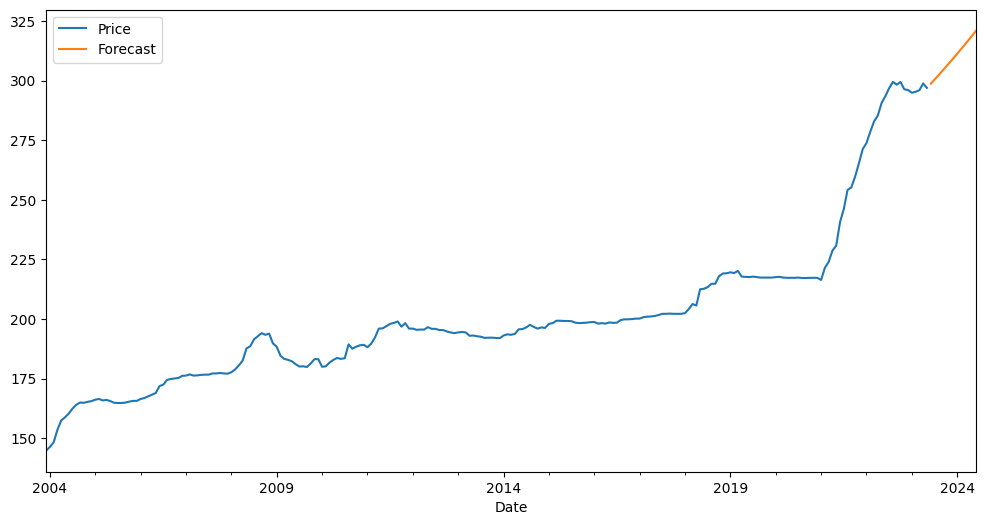

In [70]:
# First, retrain the model on the full dataset
model = AutoReg(df_new['Price'], lags=1)

# Next, fit the model
AR1fit = model.fit()

# Make predictions
fcast = AR1fit.predict(start=len(df_new), end=len(df_new)+12, dynamic=False).rename('Forecast')

# Plot the results
df_new['Price'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));

## pmdarima Auto-ARIMA

In [71]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [72]:
auto_arima(df_new['Price'],seasonal=False)

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [73]:
auto_arima(df_new['Price'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -411.343
Date:                Thu, 22 Jun 2023   AIC                            834.686
Time:                        13:13:01   BIC                            855.392
Sample:                    12-01-2003   HQIC                           843.036
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1528      0.122      1.257      0.209      -0.086       0.391
ar.L1          0.0776      0.104      0.747      0.455      -0.126       0.281
ar.L2          0.6969      0.113      6.141      0.000       0.474       0.919
ma.L1          0.1521      0.126      1.211      0.226      -0.094       0.398
ma.L2         -0.2819      0.119     -2.378      0.017      -0.514      -0.050
sigma2         1.9934      0.115     17.374      0.000       1.769       2.218
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               301.67
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Run the augmented Dickey-Fuller Test on the original data

In [74]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [75]:
adf_test(df_new['Price'],'Price')

Augmented Dickey-Fuller Test: Price
ADF test statistic        1.149038
p-value                   0.995614
# lags used               7.000000
# observations          226.000000
critical value (1%)      -3.459620
critical value (5%)      -2.874415
critical value (10%)     -2.573632
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Run the augmented Dickey-Fuller Test on the First and Second Difference

In [76]:
from statsmodels.tsa.statespace.tools import diff
df_new['d1'] = diff(df_new['Price'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df_new['d1'],'Price')

Augmented Dickey-Fuller Test: Price
ADF test statistic       -4.418434
p-value                   0.000275
# lags used               6.000000
# observations          226.000000
critical value (1%)      -3.459620
critical value (5%)      -2.874415
critical value (10%)     -2.573632
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [77]:
from statsmodels.tsa.statespace.tools import diff
df_new['d2'] = diff(df_new['Price'],k_diff=2)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df_new['d2'],'Price')

Augmented Dickey-Fuller Test: Price
ADF test statistic     -1.341416e+01
p-value                 4.315068e-25
# lags used             2.000000e+00
# observations          2.290000e+02
critical value (1%)    -3.459233e+00
critical value (5%)    -2.874245e+00
critical value (10%)   -2.573541e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run the ACF and PACF plots
This confirms that we reached stationarity after the first difference.
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>

In [78]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

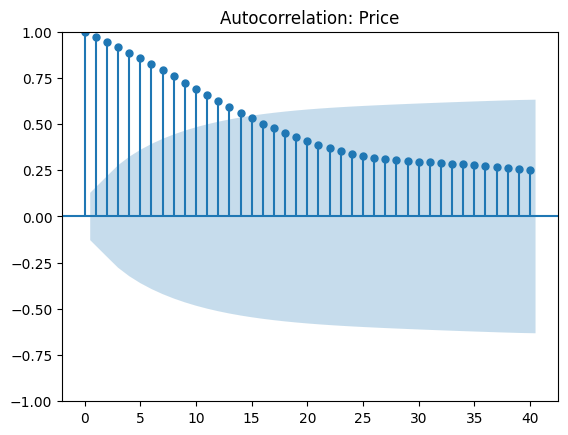

In [79]:
title = 'Autocorrelation: Price'
lags = 40
plot_acf(df_new['Price'],title=title,lags=lags);

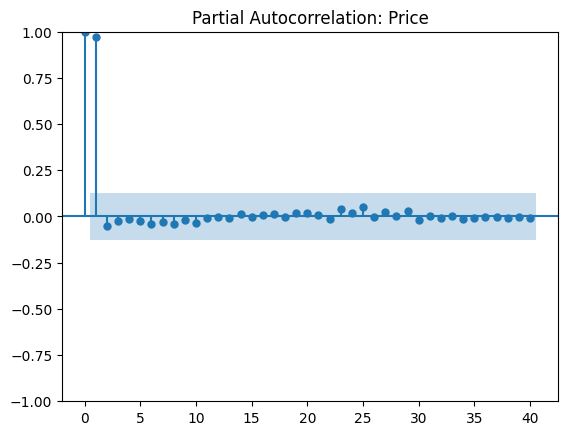

In [80]:
title = 'Partial Autocorrelation: Price'
lags = 40
plot_pacf(df_new['Price'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

### ARIMA Model

In [81]:
# Set one year for testing
train = df_new.iloc[:222]
test = df_new.iloc[222:]

In [82]:
# Load specific forecasting tools

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

In [83]:
model = ARIMA(train['Price'],order=((2,1,2)))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  222
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -386.630
Date:                Thu, 22 Jun 2023   AIC                            783.260
Time:                        13:13:01   BIC                            800.251
Sample:                    12-01-2003   HQIC                           790.121
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1337      0.114      1.178      0.239      -0.089       0.356
ar.L2          0.7545      0.135      5.575      0.000       0.489       1.020
ma.L1          0.1058      0.135      0.786      0.432      -0.158       0.370
ma.L2         -0.3493      0.137     -2.541      0.011      -0.619      -0.080
sigma2         1.9271      0.106     18.143      0.000       1.719       2.135
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               331.99
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             1.13
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARIMA((2,1,2)) Predictions')

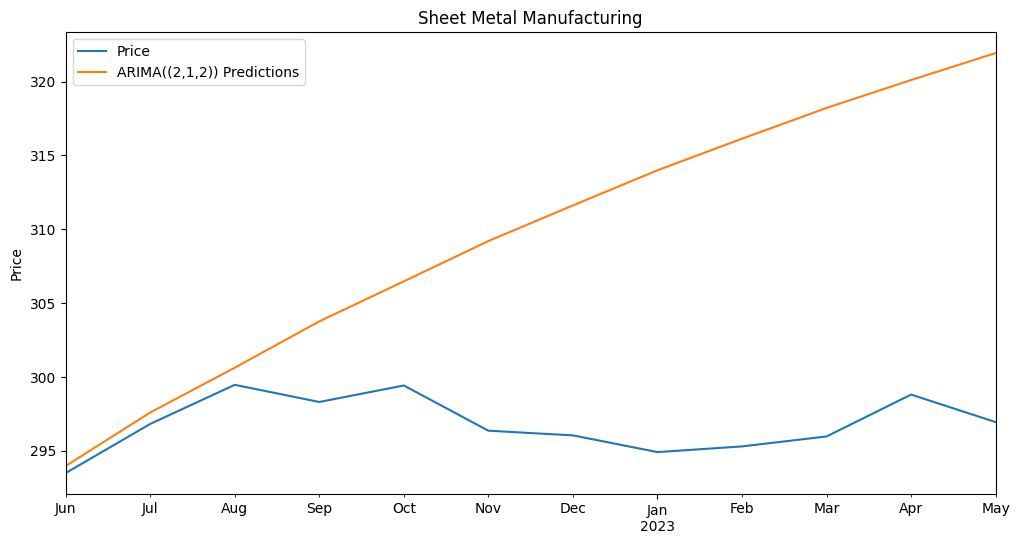

In [85]:
title = 'Sheet Metal Manufacturing'
ylabel='Price'
xlabel='' # we don't really need a label here

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [86]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA((2,1,2) Predictions')

Passing dynamic=False means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing typ='levels' predicts the levels of the original endogenous variables. If we'd used the default typ='linear' we would have seen linear predictions in terms of the differenced endogenous variables.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [87]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Price'][i]}")

predicted=293.9606497, expected=293.483
predicted=297.585208 , expected=296.81
predicted=300.6199051, expected=299.462
predicted=303.7605053, expected=298.299
predicted=306.4702119, expected=299.416
predicted=309.2021995, expected=296.354
predicted=311.612053 , expected=296.037
predicted=313.9956384, expected=294.904
predicted=316.1326575, expected=295.29
predicted=318.2168834, expected=295.964
predicted=320.1080123, expected=298.801
predicted=321.9334853, expected=296.936


In [88]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

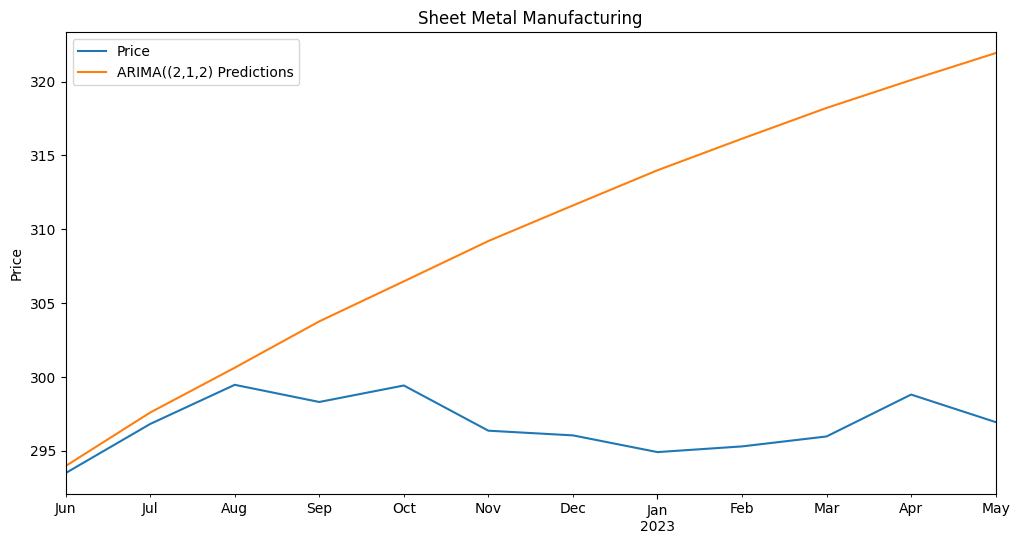

In [89]:
# Plot predictions against known values
title = 'Sheet Metal Manufacturing'
ylabel='Price'
xlabel='' # we don't really need a label here

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Evaluate the Model

In [90]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Price'], predictions)
print(f'ARIMA(2,1,2) MSE Error: {error:11.10}')

ARIMA(2,1,2) MSE Error: 238.5315984


In [91]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Price'], predictions)
print(f'ARIMA(2,1,2) RMSE Error: {error:11.10}')

ARIMA(2,1,2) RMSE Error: 15.44446821


In [92]:
df_new['Price'].mean()

201.2184444444445

In [93]:
predictions.mean()

309.4664507730663

### Retrain the model on the full data, and forecast the future

In [94]:
model = ARIMA(df_new['Price'],order=(2,1,2))
results = model.fit()
fcast = results.predict(len(df_new),len(df_new)+11,typ='levels').rename('ARIMA(2,1,2) Forecast')

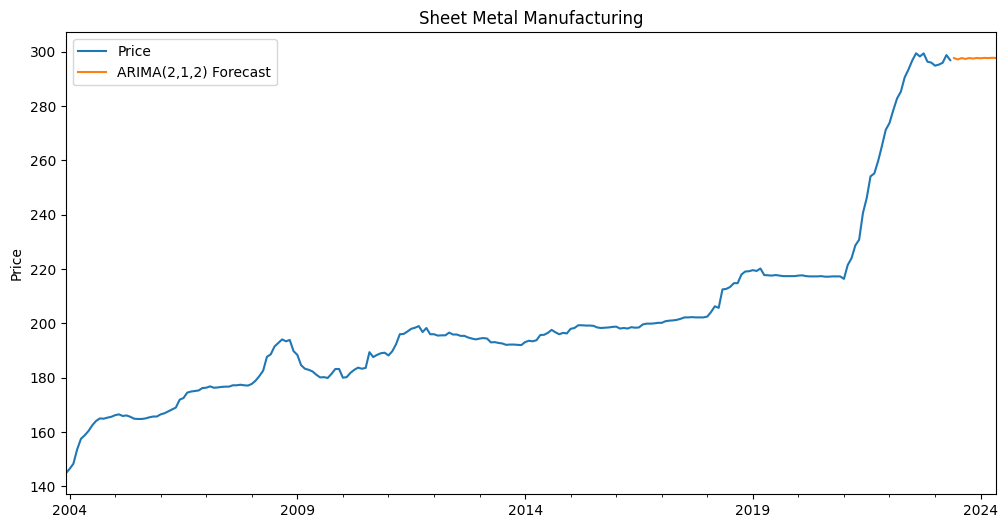

In [95]:
# Plot predictions against known values
title = 'Sheet Metal Manufacturing'
ylabel='Price'
xlabel='' # we don't really need a label here

ax = df_new['Price'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [97]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df_new['Price'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -413.326
Date:                Thu, 22 Jun 2023   AIC                            834.651
Time:                        13:13:03   BIC                            848.455
Sample:                    12-01-2003   HQIC                           840.218
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2060      0.128      1.604      0.109      -0.046       0.458
ar.L1          0.2409      0.048      5.035      0.000       0.147       0.335
ar.L2          0.4464      0.046      9.770      0.000       0.357       0.536
sigma2         2.0282      0.115     17.683      0.000       1.803       2.253
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               305.07
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
model = SARIMAX(train['Price'],order=(2, 1, 0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  222
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -391.002
Date:                Thu, 22 Jun 2023   AIC                            788.004
Time:                        13:13:03   BIC                            798.199
Sample:                    12-01-2003   HQIC                           792.120
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2875      0.044      6.546      0.000       0.201       0.374
ar.L2          0.4715      0.046     10.291      0.000       0.382       0.561
sigma2         2.0072      0.104     19.373      0.000       1.804       2.210
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):               327.97
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [99]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA order=(2, 1, 0) Predictions')

In [100]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Price'][i]}")

predicted=293.2681112, expected=293.483
predicted=296.5028509, expected=296.81
predicted=298.6998007, expected=299.462
predicted=300.856611 , expected=298.299
predicted=302.5125528, expected=299.416
predicted=304.0055748, expected=296.354
predicted=305.2155946, expected=296.037
predicted=306.2674362, expected=294.904
predicted=307.140365 , expected=295.29
predicted=307.8872758, expected=295.964
predicted=308.5135988, expected=298.801
predicted=309.0458354, expected=296.936


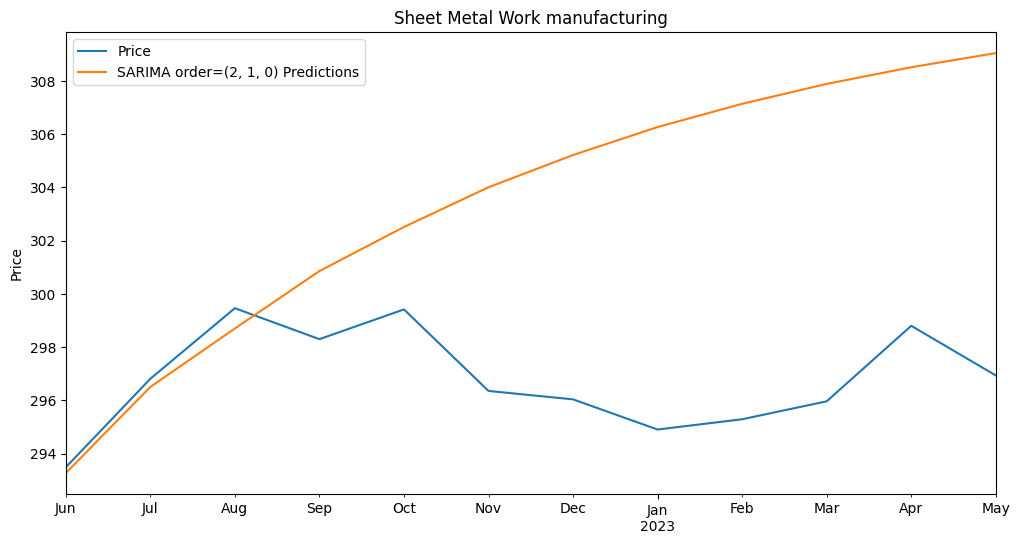

In [101]:
# Plot predictions against known values
title = 'Sheet Metal Work manufacturing'
ylabel='Price'
xlabel=''

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [102]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Price'], predictions)
print(f'SARIMA order=(2, 1, 0) MSE Error: {error:11.10}')

SARIMA order=(2, 1, 0) MSE Error: 67.69589151


In [103]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Price'], predictions)
print(f'SARIMA order=(2, 1, 0) RMSE Error: {error:11.10}')

SARIMA order=(2, 1, 0) RMSE Error: 8.227751303


In [104]:
model = SARIMAX(df_new['Price'],order=(0,2,1),seasonal_order=(2, 0, [1, 2], 12))
results = model.fit()
fcast = results.predict(len(df_new),len(df_new)+11,typ='levels').rename('SARIMA order=(2, 1, 0) Forecast')

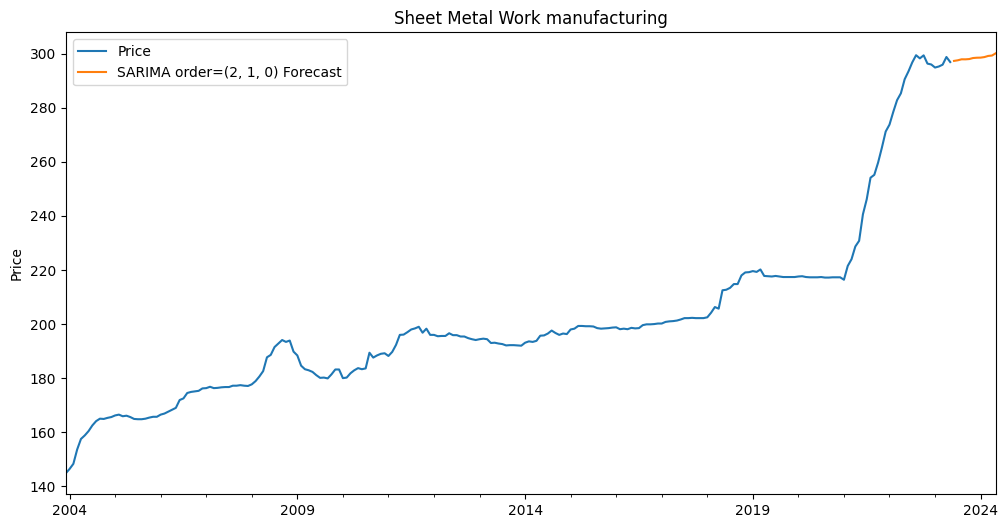

In [105]:
# Plot predictions against known values
title = 'Sheet Metal Work manufacturing'
ylabel='Price'
xlabel=''

ax = df_new['Price'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);